# Most Streamed Spotify Songs 2024 EDA


In [51]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import re
from collections import Counter
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
df = pd.read_csv("/Users/mani/Desktop/eda/data/Most Streamed Spotify Songs 2024.csv", encoding='latin1')

In [53]:
# Initial Data Exploration
df.info()
print('\n------ Percentage null ------\n')
print(df.isnull().sum() / len(df) * 100)
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Track                       4600 non-null   object 
 1   Album Name                  4600 non-null   object 
 2   Artist                      4595 non-null   object 
 3   Release Date                4600 non-null   object 
 4   ISRC                        4600 non-null   object 
 5   All Time Rank               4600 non-null   object 
 6   Track Score                 4600 non-null   float64
 7   Spotify Streams             4487 non-null   object 
 8   Spotify Playlist Count      4530 non-null   object 
 9   Spotify Playlist Reach      4528 non-null   object 
 10  Spotify Popularity          3796 non-null   float64
 11  YouTube Views               4292 non-null   object 
 12  YouTube Likes               4285 non-null   object 
 13  TikTok Posts                3427 

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0


## Data Cleaning & Numeric Conversion


In [54]:
# Drop completely null column
df = df.drop(columns=['TIDAL Popularity'], errors='ignore')

# Columns to convert from string to numeric
platform_cols = [
    'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity',
    'YouTube Views', 'YouTube Likes', 'YouTube Playlist Reach',
    'TikTok Posts', 'TikTok Likes', 'TikTok Views',
    'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
    'Deezer Playlist Count', 'Deezer Playlist Reach',
    'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
    'Soundcloud Streams', 'Shazam Counts'
]

# Remove commas, convert to numeric
for col in platform_cols:
    df[col] = df[col].astype(str).str.replace(',', '').replace('nan', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Summary statistics
summary = df[platform_cols].describe().transpose()
print(summary[['count', 'mean', 'min', 'max']])

                             count          mean     min           max
Spotify Streams             4487.0  4.473873e+08  1071.0  4.281469e+09
Spotify Playlist Count      4530.0  5.939083e+04     1.0  5.903920e+05
Spotify Playlist Reach      4528.0  2.334682e+07     1.0  2.623434e+08
Spotify Popularity          3796.0  6.350158e+01     1.0  9.600000e+01
YouTube Views               4292.0  4.027967e+08   913.0  1.632276e+10
YouTube Likes               4285.0  2.930049e+06    25.0  6.231118e+07
YouTube Playlist Reach      3591.0  3.439601e+08     1.0  7.289707e+09
TikTok Posts                3427.0  9.443076e+05     1.0  4.290000e+07
TikTok Likes                3620.0  1.126375e+08     3.0  2.347422e+10
TikTok Views                3619.0  1.161158e+09    19.0  2.332323e+11
Apple Music Playlist Count  4039.0  5.460312e+01     1.0  8.590000e+02
AirPlay Spins               4102.0  5.513916e+04     1.0  1.777811e+06
SiriusXM Spins              2477.0  2.573444e+02     1.0  7.098000e+03
Deezer

## Distributions of Key Metrics


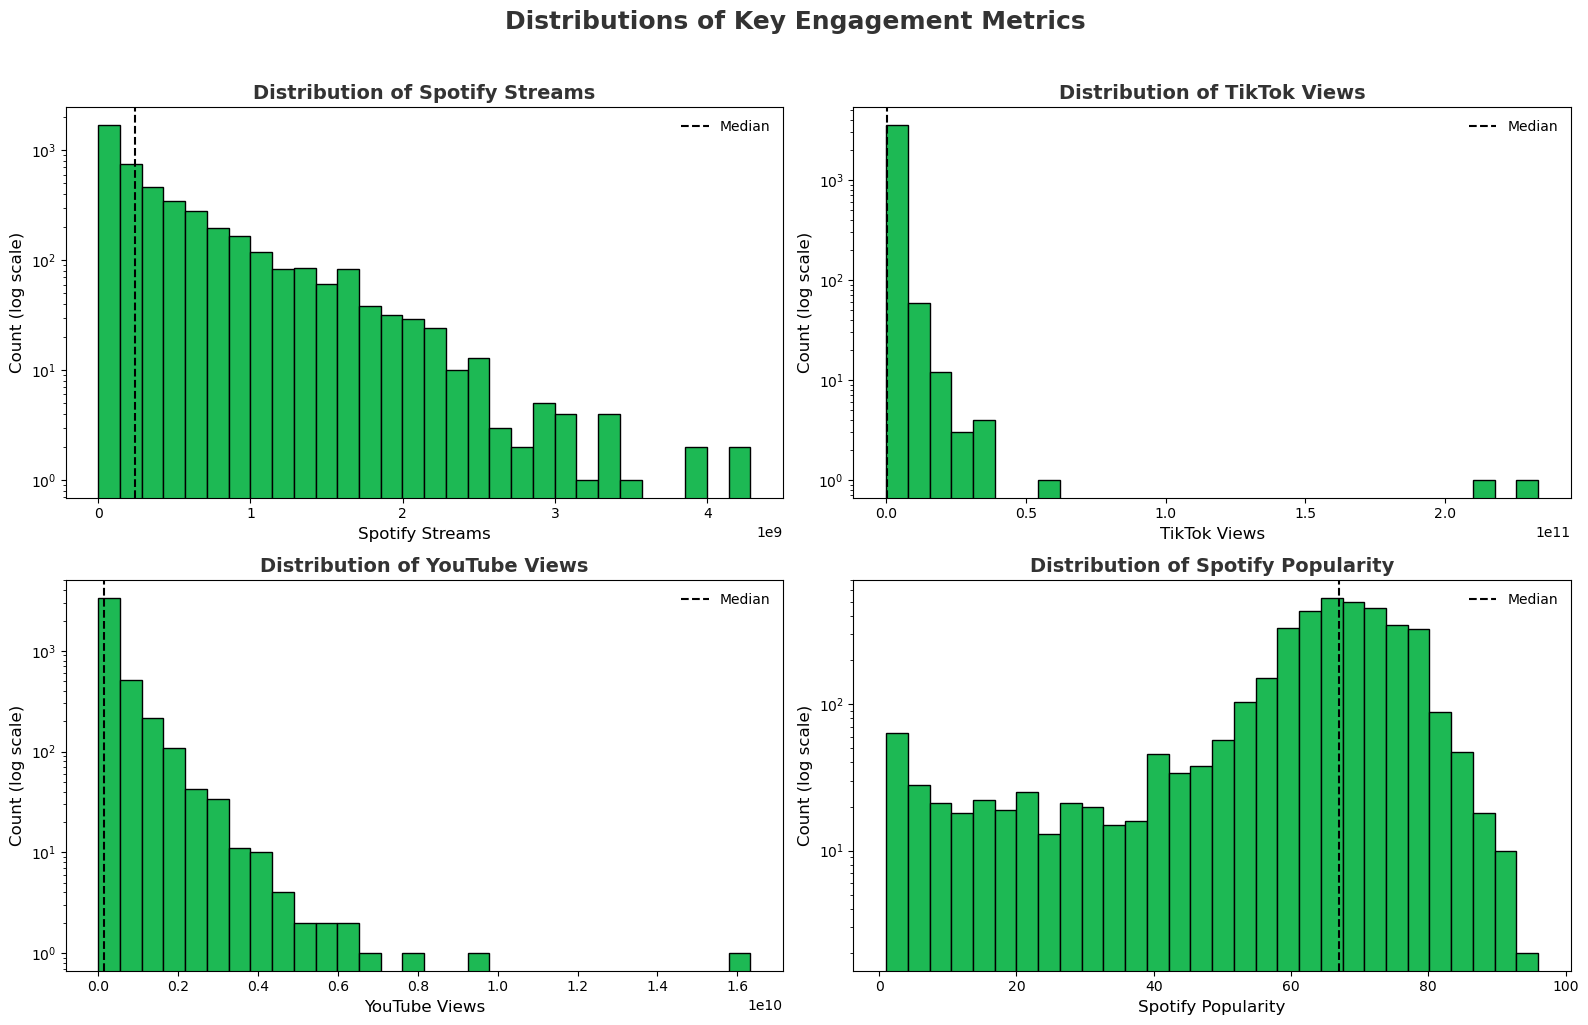

In [55]:
# Define Spotify theme colors
spotify_green = "#1DB954"
neutral_gray = "#333333"
spotify_dark_gray = "#191414"
spotify_light_gray = "#B3B3B3"

cols_to_plot = ['Spotify Streams', 'TikTok Views', 'YouTube Views', 'Spotify Popularity']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for ax, col in zip(axes.flat, cols_to_plot):
    data = df[col].dropna()

    counts, bin_edges = np.histogram(data, bins=30)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    ax.bar(bin_centers, counts, width=np.diff(bin_edges), align='center',
           color=spotify_green, edgecolor='black', log=True)

    median_val = np.median(data)
    ax.axvline(median_val, color='black', linestyle='--', linewidth=1.5, label='Median')

    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold', color=neutral_gray)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count (log scale)', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

    ax.legend(frameon=False, fontsize=10, loc='upper right')

plt.suptitle('Distributions of Key Engagement Metrics', fontsize=18, fontweight='bold', color=neutral_gray, y=1.02)
plt.tight_layout()
plt.show()


#### Insights:

- Spotify Streams, TiKTok Views, and YouTube Views seem pretty heavily right skewed, especially TikTok views. This indicating that most views/streams tend to be lower, except for the few viral videos in the tail.
- Spotify Popularity though looks more normal, with a slight right skew.


## Correlations and Cross-Platform Relationships


In [56]:
corr_cols = ['Spotify Streams', 'TikTok Views', 'YouTube Views', 'Spotify Popularity', 'Spotify Playlist Count']
corr_matrix = df[corr_cols].corr()
print("Correlation Matrix:")
corr_matrix

Correlation Matrix:


,Spotify Streams,TikTok Views,YouTube Views,Spotify Popularity,Spotify Playlist Count
Spotify Streams,1.000000,0.030481,0.468619,0.359931,0.815083
TikTok Views,0.030481,1.000000,0.003535,-0.059513,0.035026
YouTube Views,0.468619,0.003535,1.000000,0.035983,0.322035
Spotify Popularity,0.359931,-0.059513,0.035983,1.000000,0.390597
Spotify Playlist Count,0.815083,0.035026,0.322035,0.390597,1.000000


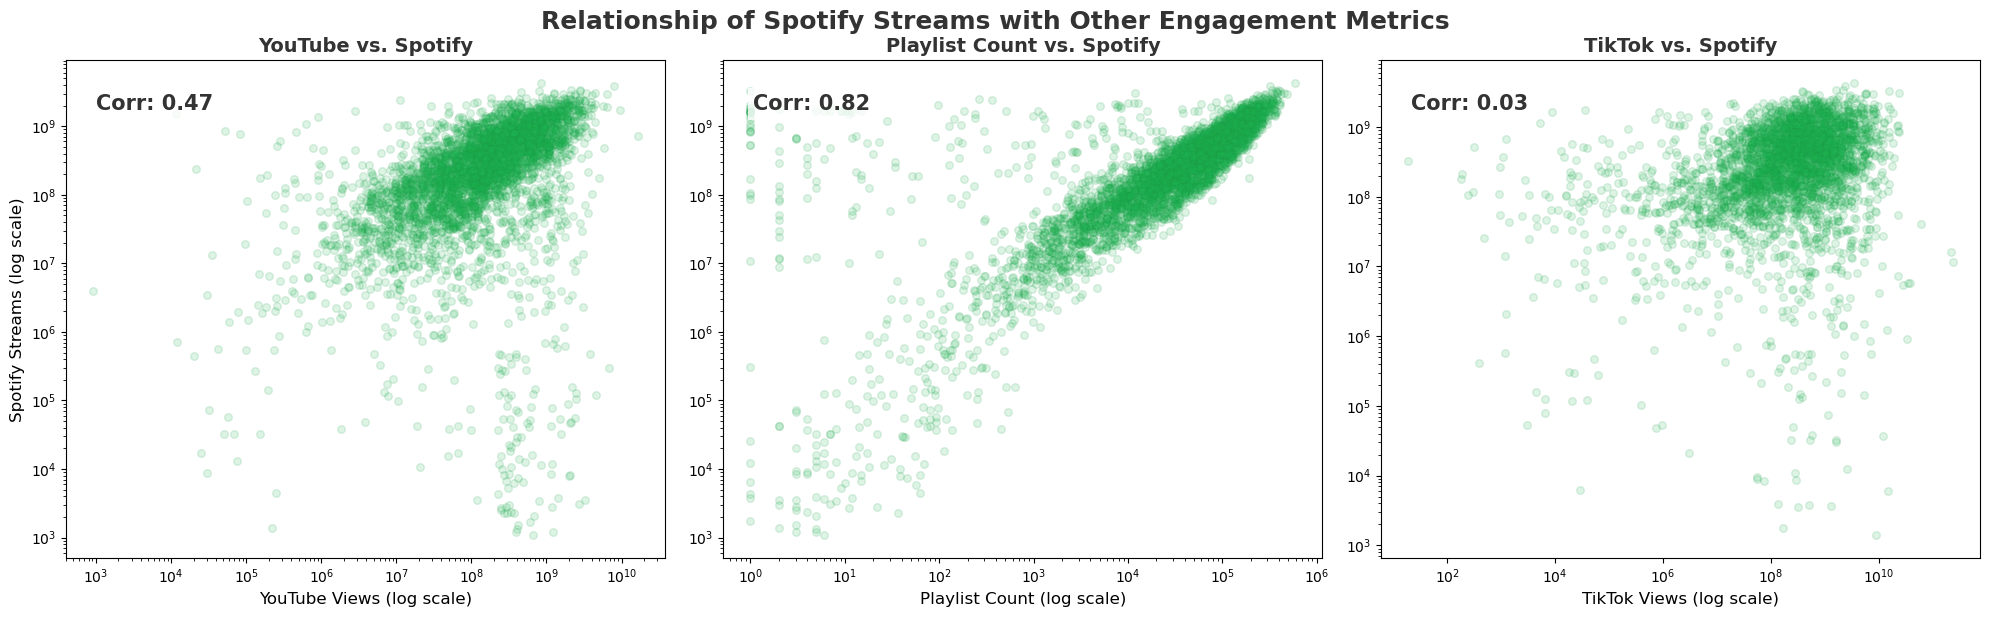

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
fig.patch.set_facecolor('white')

pairs = [
    ('YouTube Views', 'Spotify Streams', 'YouTube Views (log scale)', 'YouTube vs. Spotify'),
    ('Spotify Playlist Count', 'Spotify Streams', 'Playlist Count (log scale)', 'Playlist Count vs. Spotify'),
    ('TikTok Views', 'Spotify Streams', 'TikTok Views (log scale)', 'TikTok vs. Spotify')
]

correlations = {x: df[x].corr(df['Spotify Streams']) for x, _, _, _ in pairs}

for ax, (x_col, y_col, xlabel, title) in zip(axs, pairs):
    ax.scatter(df[x_col], df[y_col], alpha=0.15, color=spotify_green, edgecolor='#1A9B47', s=30)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_title(title, fontsize=14, fontweight='bold', color=neutral_gray)
    ax.set_xlabel(xlabel, fontsize=12)
    if ax == axs[0]:
        ax.set_ylabel('Spotify Streams (log scale)', fontsize=12)
    else:
        ax.set_ylabel('')

    # Correlation annotation (rounded to 2 decimals) in upper left corner
    corr_val = correlations[x_col]
    ax.text(0.05, 0.9, f'Corr: {corr_val:.2f}', transform=ax.transAxes,
            fontsize=15, fontweight='bold', color=neutral_gray,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Adjust layout to avoid label overlap
plt.tight_layout()

# Main title for the figure
plt.suptitle('Relationship of Spotify Streams with Other Engagement Metrics', fontsize=18, fontweight='bold', color=neutral_gray, y=1.02)

plt.show()

#### Insights:

- Surprisingly, TikTok Views and Spotify Streams has a low correlation! Meaning a viral TikTok video doesn't mean the song will necessarily do well.
- YouTube Views seem to have more of a correlation. This could be due to music video watches.
- Spotify Playlist count has the largest correlation of 0.815.


## Outliers


Since YouTube Views is positively correlated with Spotify Streams, let's see if there are any songs that might be popular on Youtube but aren't streamed much on Spotify.


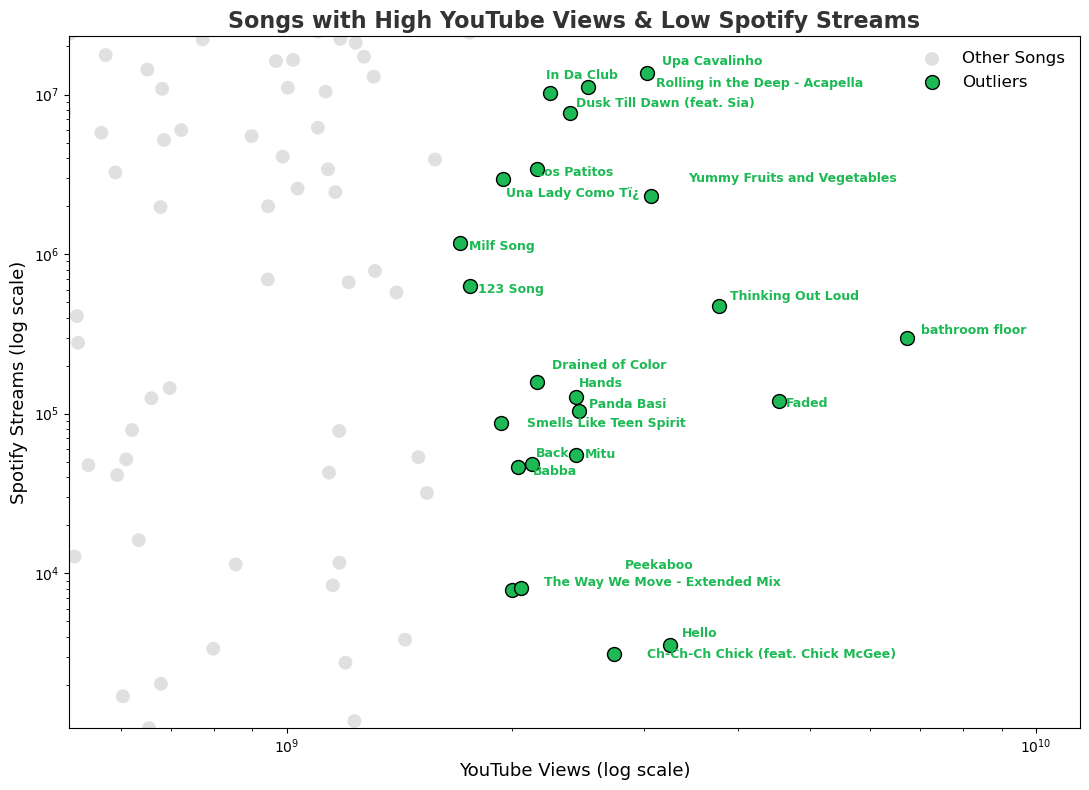

Songs with High YouTube Views and Low Spotify Streams:


,Track,Artist,YouTube Views,Spotify Streams
14,bathroom floor,Kids With Buns,6.736502e+09,297185.0
458,Faded,Benjamin Richter,4.542998e+09,120162.0
696,Thinking Out Loud,Ed Sheeran,3.777105e+09,473328.0
1273,Hello,Muramatsu Karaoke,3.250879e+09,3531.0
260,Yummy Fruits and Vegetables,D Billions,3.060919e+09,2300838.0
1491,Upa Cavalinho,Galinha Pintadinha,3.024886e+09,13615330.0
2511,Ch-Ch-Ch Chick (feat. Chick McGee),Bob and Tom,2.730591e+09,3115.0
2807,Rolling in the Deep - Acapella,Adele,2.522903e+09,11170019.0
51,Panda Basi,Mvua,2.457027e+09,104271.0
115,Hands,Dianï¿½,2.435814e+09,126914.0


In [58]:
q95_youtube = df['YouTube Views'].quantile(0.95)
q10_spotify = df['Spotify Streams'].quantile(0.10)

outliers = df[(df['YouTube Views'] > q95_youtube) & (df['Spotify Streams'] < q10_spotify)]

plt.figure(figsize=(11, 8))
plt.scatter(df['YouTube Views'], df['Spotify Streams'], alpha=0.15, label='Other Songs', color=neutral_gray, edgecolor='none', s=100)
plt.scatter(outliers['YouTube Views'], outliers['Spotify Streams'], color=spotify_green, label='Outliers', s=100, edgecolor='black')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('YouTube Views (log scale)', fontsize=13)
plt.ylabel('Spotify Streams (log scale)', fontsize=13)
plt.title('Songs with High YouTube Views & Low Spotify Streams', fontsize=16, fontweight='bold', color=neutral_gray)

x_min = max(df['YouTube Views'].min(), outliers['YouTube Views'].min() * 0.3)
x_max = min(df['YouTube Views'].max(), outliers['YouTube Views'].max() * 1.7)

y_min = max(df['Spotify Streams'].min(), outliers['Spotify Streams'].min() * 0.3)
y_max = min(df['Spotify Streams'].max(), outliers['Spotify Streams'].max() * 1.7)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

texts = []
for i, row in outliers.iterrows():
    texts.append(
        plt.text(row['YouTube Views'], row['Spotify Streams'], row['Track'],
                 fontsize=9, fontweight='bold', color=spotify_green)
    )

adjust_text(texts,
            expand_points=(1.2, 1.4),
            force_text=0.1,
            force_points=0.1)

plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.show()

outliers_display = outliers[['Track', 'Artist', 'YouTube Views', 'Spotify Streams']].copy()
outliers_display = outliers_display.sort_values(by='YouTube Views', ascending=False)
print("Songs with High YouTube Views and Low Spotify Streams:")
display(outliers_display)

#### Insights:

Spotify could advertise these songs on their platform/algorithm. Success on YouTube may be a good indicator of success on Spotify based on their correlation.


## Most Common Words in Track Titles


In [59]:
# PREPROCESSING STEPS 
df['clean_track'] = df['Track'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
all_words = ' '.join(df['clean_track']).split()
stopwords = list(set(STOPWORDS).union({'feat', 'ft', 'remix', 'official', 'video'}))
filtered_words = [w for w in all_words if w not in stopwords]
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(20)
top_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

results = []
for word in top_words_df['word']:
    df['has_word'] = df['clean_track'].apply(lambda x: word in x.split())
    avg_with = df.loc[df['has_word'], 'Spotify Streams'].mean()
    avg_without = df.loc[~df['has_word'], 'Spotify Streams'].mean()
    results.append({'word': word, 'With Word': avg_with, 'Without Word': avg_without})
results_df = pd.DataFrame(results)

plot_df = results_df.melt(id_vars='word', value_vars=['With Word', 'Without Word'],
                          var_name='Presence', value_name='Average Spotify Streams')

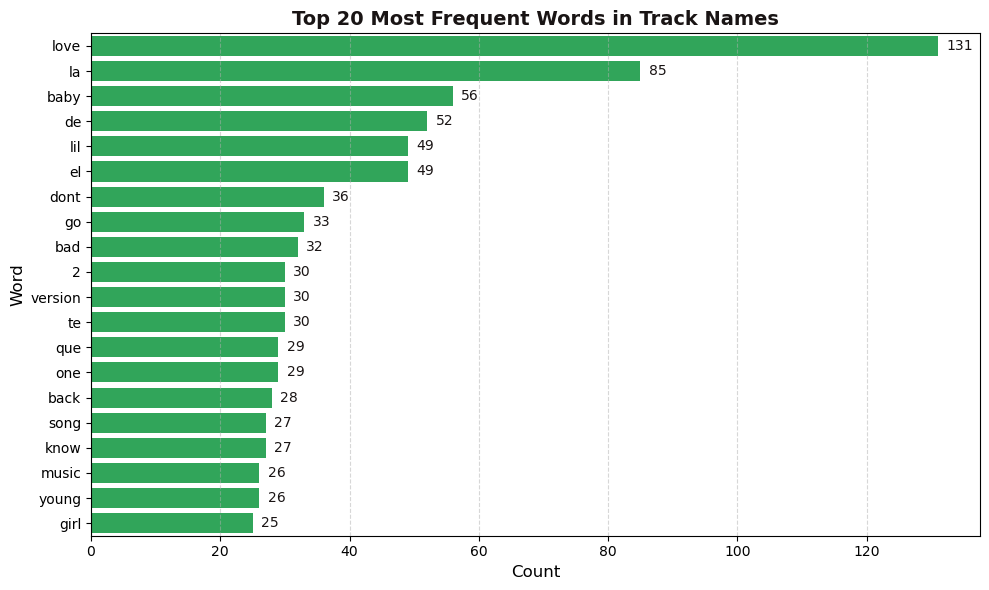

In [60]:
# PLOT 1: Top 20 Most Frequent Words in Track Names
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_words_df,
    x='count',
    y='word',
    color=spotify_green)

plt.title('Top 20 Most Frequent Words in Track Names', fontsize=14, weight='bold', color=spotify_dark_gray)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

for index, row in top_words_df.iterrows():
    plt.text(row['count'] + max(top_words_df['count']) * 0.01, index, f"{row['count']:,}", 
             va='center', ha='left', color=spotify_dark_gray, fontsize=10)

plt.show()

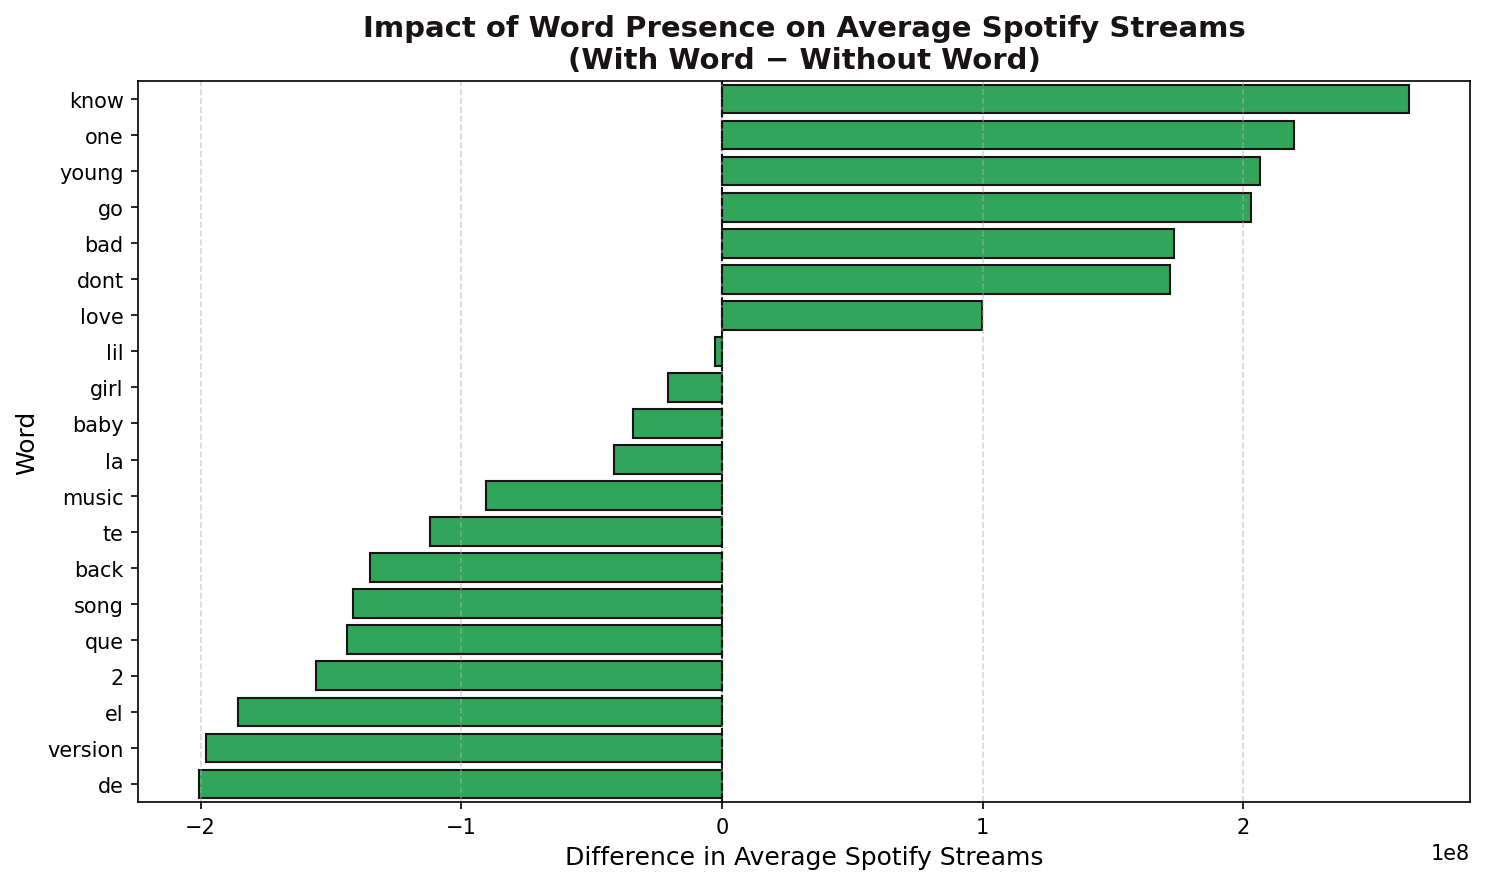

In [61]:
results_df['diff'] = results_df['With Word'] - results_df['Without Word']
results_df = results_df.sort_values('diff', ascending=False).reset_index(drop=True)


# PLOT 2: Difference in Average Streams (With and Without Top Words)
plt.figure(figsize=(10, 6), dpi=150)

sns.barplot(
    data=results_df,
    y='word',
    x='diff',
    color=spotify_green,
    edgecolor=spotify_dark_gray
)

# Reference line at zero
plt.axvline(0, color=spotify_dark_gray, linestyle='--', linewidth=1)

plt.title('Impact of Word Presence on Average Spotify Streams\n(With Word − Without Word)', 
          fontsize=14, weight='bold', color=spotify_dark_gray)
plt.xlabel('Difference in Average Spotify Streams', fontsize=12)
plt.ylabel('Word', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Insights:

- Words like "know," "one," "young," "go," "bad," "dont," and "love" are linked to significantly higher average streams (+200M+).
- Words like "music," "back," "song," "version," "de," "el," "la," "baby," "girl," and "lil" correlate with lower average streams (up to -200M).
- High-frequency positive words (e.g., "love") show moderate boosts, while some less common words (e.g., "know") have very large positive effects.
- Generic or language-specific words often relate to lower streams, suggesting audience and context matter.


## Track and Artist Dominance

We were curious about the impact of top aritsts and top ranked tracks have on the total Spotify streams from the dataset. The relationship between track and artist rank (sorted based on number of Spotify Streams) are explored in the following visualizations.

### Track Dominance

In [62]:
df_sorted = df.sort_values(by = 'Spotify Streams', ascending = False)
df_sorted['Cumulative Streams'] = df_sorted['Spotify Streams'].cumsum()
df_sorted['Cumulative Proportion of Streams'] = df_sorted['Cumulative Streams'] /df_sorted['Spotify Streams'].sum()
df_sorted = df_sorted.reset_index(drop=True)
df_sorted['Track Rank'] = df_sorted.index + 1

In [63]:
num_explicit_top_664 = df_sorted.head(664)['Explicit Track'].sum()
num_explicit_top_664

np.int64(229)

In [64]:
num_explicit_top_2210 = df_sorted.head(2210)['Explicit Track'].sum()
num_explicit_top_2210

np.int64(835)

In [65]:
df.groupby('Explicit Track')['Track'].count()

Explicit Track
0    2949
1    1651
Name: Track, dtype: int64

In [66]:
df.groupby('Explicit Track')['Spotify Streams'].sum()

Explicit Track
0    1.276162e+12
1    7.312645e+11
Name: Spotify Streams, dtype: float64

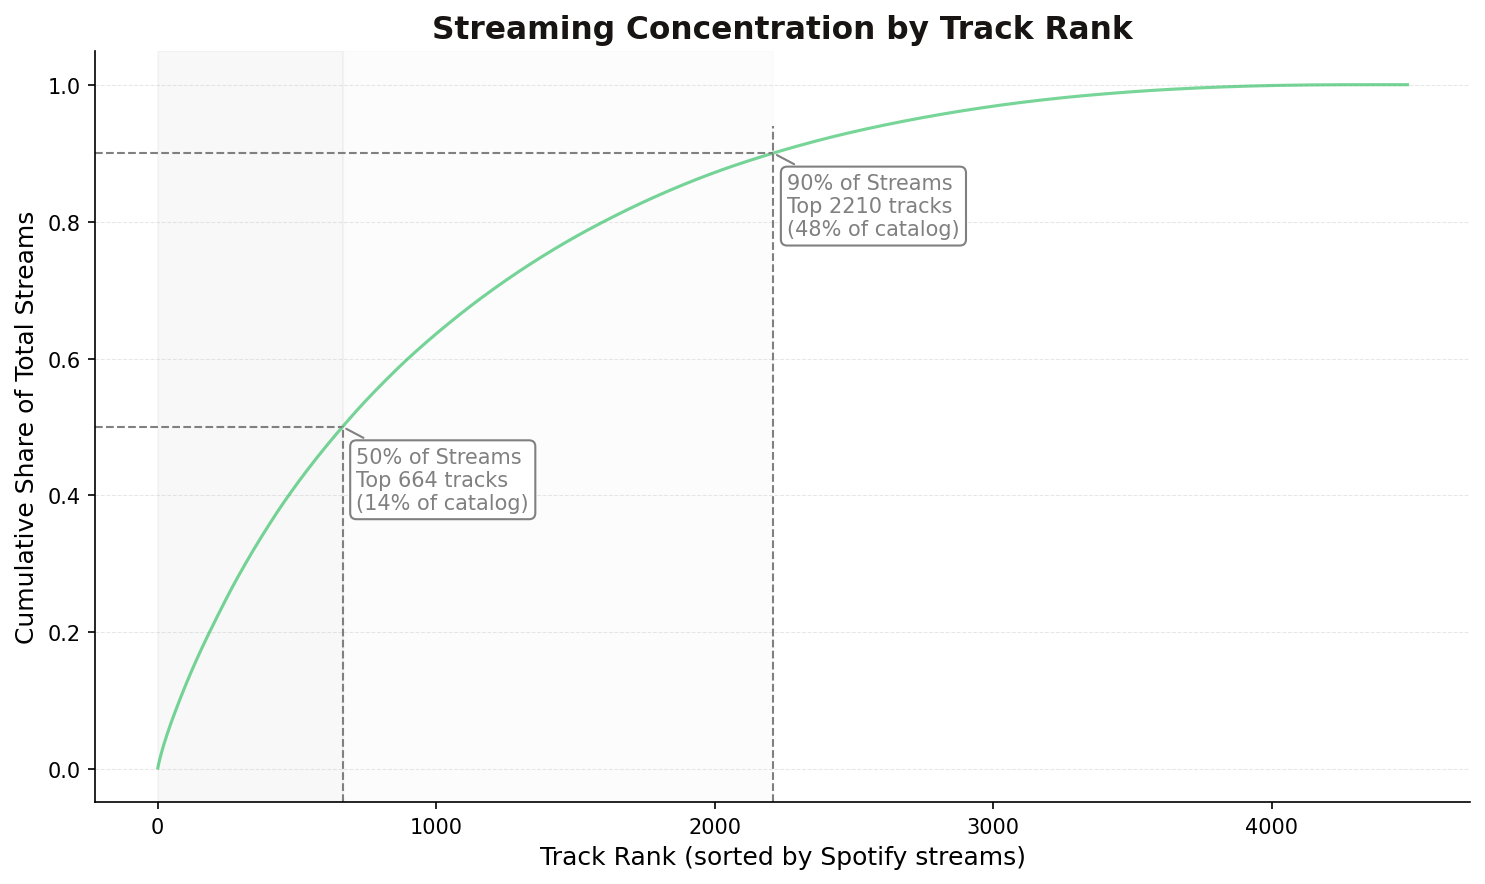

In [67]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Plot the cumulative distribution curve
ax.plot(
    df_sorted['Track Rank'],
    df_sorted['Cumulative Proportion of Streams'],
    color='#1DB954',
    linestyle='-',
    alpha=0.6
)

def annotate_cutoff(ax, df, cutoff, rank_col, value_col, label, color='gray', offset=50):
    idx = (df[value_col] >= cutoff).idxmax()
    rank = df.loc[idx, rank_col]
    value = df.loc[idx, value_col]

    # Get current x-axis limits
    x_min, x_max = ax.get_xlim()

    # Calculate xmax in axis fraction units (0 to 1) for axhline
    xmax_frac = (rank - x_min) / (x_max - x_min)

    # Reference lines
    ax.axhline(value, xmax=xmax_frac, color=color, linestyle='--', linewidth=1)
    ax.axvline(rank, ymax=value, color=color, linestyle='--', linewidth=1)

    # Annotation text
    ax.annotate(
        f'{label}\nTop {rank} tracks\n({rank / len(df):.0%} of catalog)',
        xy=(rank, value),
        xytext=(rank + offset, value - 0.12),
        fontsize=10,
        color=color,
        arrowprops=dict(arrowstyle='-', color=color),
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
    )
    return rank

# Annotate cutoffs
half = annotate_cutoff(ax, df_sorted, 0.5, 'Track Rank', 'Cumulative Proportion of Streams', '50% of Streams')
ninety = annotate_cutoff(ax, df_sorted, 0.9, 'Track Rank', 'Cumulative Proportion of Streams', '90% of Streams')

# Add shaded zones to suggest zones of interest
ax.axvspan(0, half, color='gray', alpha=0.05)
ax.axvspan(half, ninety, color='gray', alpha=0.025)

ax.set_title("Streaming Concentration by Track Rank", fontsize=15, weight='bold', color='#191414')
ax.set_xlabel("Track Rank (sorted by Spotify streams)", fontsize=12)
ax.set_ylabel("Cumulative Share of Total Streams", fontsize=12)

# Hide top and right spines properly
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)
plt.tight_layout()
plt.show()

### Artist Dominance

In [68]:
# Load and group by artist
df_artist = df.groupby("Artist", as_index=False)['Spotify Streams'].sum()

# Sort by total streams descending
df_artist_sorted = df_artist.sort_values(by='Spotify Streams', ascending=False)
df_artist_sorted['Cumulative Streams'] = df_artist_sorted['Spotify Streams'].cumsum()
df_artist_sorted['Cumulative Proportion of Streams'] = (
    df_artist_sorted['Cumulative Streams'] / df_artist_sorted['Spotify Streams'].sum()
)
df_artist_sorted = df_artist_sorted.reset_index(drop=True)
df_artist_sorted['Artist Rank'] = df_artist_sorted.index + 1

In [69]:
df_artist_sorted.nunique()

Artist                              1999
Spotify Streams                     1919
Cumulative Streams                  1919
Cumulative Proportion of Streams    1919
Artist Rank                         1999
dtype: int64

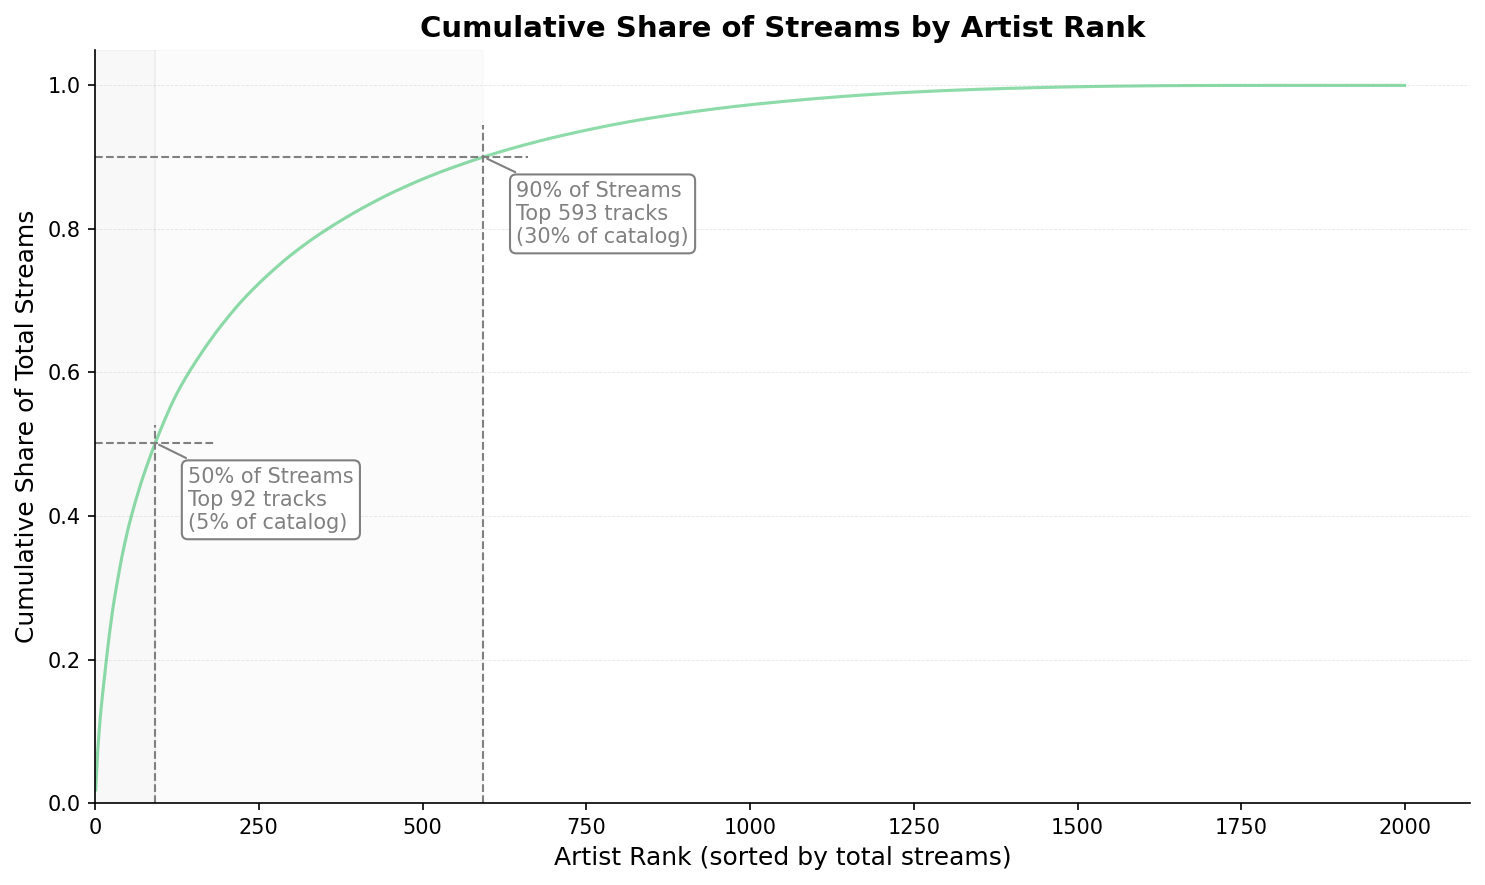

In [70]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

ax.plot(
    df_artist_sorted['Artist Rank'],
    df_artist_sorted['Cumulative Proportion of Streams'],
    color='#1DB954',
    linestyle='-',
    alpha=0.5
)

# Annotate 50% and 90% cutoffs
half = annotate_cutoff(
    ax, df_artist_sorted, 0.5,
    rank_col='Artist Rank',
    value_col='Cumulative Proportion of Streams',
    label='50% of Streams',
    color='gray'
)

ninety = annotate_cutoff(
    ax, df_artist_sorted, 0.9,
    rank_col='Artist Rank',
    value_col='Cumulative Proportion of Streams',
    label='90% of Streams',
    color='gray'
)

# Shaded regions for visual zones
ax.axvspan(0, half, color='gray', alpha=0.05)
ax.axvspan(half, ninety, color='gray', alpha=0.03)

# Titles and labels
ax.set_title("Cumulative Share of Streams by Artist Rank", fontsize=14, weight='bold')
ax.set_xlabel("Artist Rank (sorted by total streams)", fontsize=12)
ax.set_ylabel("Cumulative Share of Total Streams", fontsize=12)
ax.set_xlim(0, None)
ax.set_ylim(0, 1.05)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.grid(axis='y', linestyle='--', linewidth=0.4, alpha=0.3)
plt.tight_layout()
plt.show()


#### Insights

The majority of Spotify streams can be accounted for by a relatively small portion of the top artists and tracks.

##### Track Dominance

- After sorting and ranking tracks based on their Spotify streams, it was found that 50% of all streams can be attributed to the top 664 tracks (out of the total 4,487 tracks in the dataset). In addition 90% of all streams are attributed to the top 2,210 tracks; or in other words 90% of all streams can be attributed to the top 50% of all tracks.

- The majority of the top 90% ranked tracks are non-explicit tracks, although non-explicit tracks still account for a substantial number of tracks. For the entire dataset, the number of explicit and non-explicit tracks account for 2,949 and 1,651 tracks of the amongst all tracks in the dataset respectively.

- The number of Spotify streams for explicit and non-explicit tracks are as follows:
  - **Non-Explicit**: 1.276162e+12 streams
  - **Explicit**: 7.312645e+11 streams

##### Artists Dominance

Similarly, we grouped the artists, summed their total Spotify streams and after sorting and ranking artists based on their total streams, it was found that 50% of all streams can be attributed to the top 92 artists (out of the total 1,999 artists in the dataset).

In addition 90% of all streams are attributed to the top 593 artists. In this case, 90% of all streams can be attributed to the top 30% of all artists.

#### Strategy

- Alongside other metrics such as YouTube views, Spotify may be able to better identify artists that would perform well on the platform. The team could evaluate the feasibility and ROI of exclusive artist deals to strengthen platform loyalty.

- Explicit songs, which account for a significant portion of Spotify streams, generally limit ad revenue potential. The team could consider differentiated payout models for explicit vs clean content

### Appendix - Other Plots

Other plots were developed but will not be used in the the presentation given there didn't seem to be any strong correlation or interesting insights discovered.

In [71]:
df['Release Date'] = pd.to_datetime(df['Release Date'])
df['Year'] = df['Release Date'].dt.year
df['Month'] = df['Release Date'].dt.month

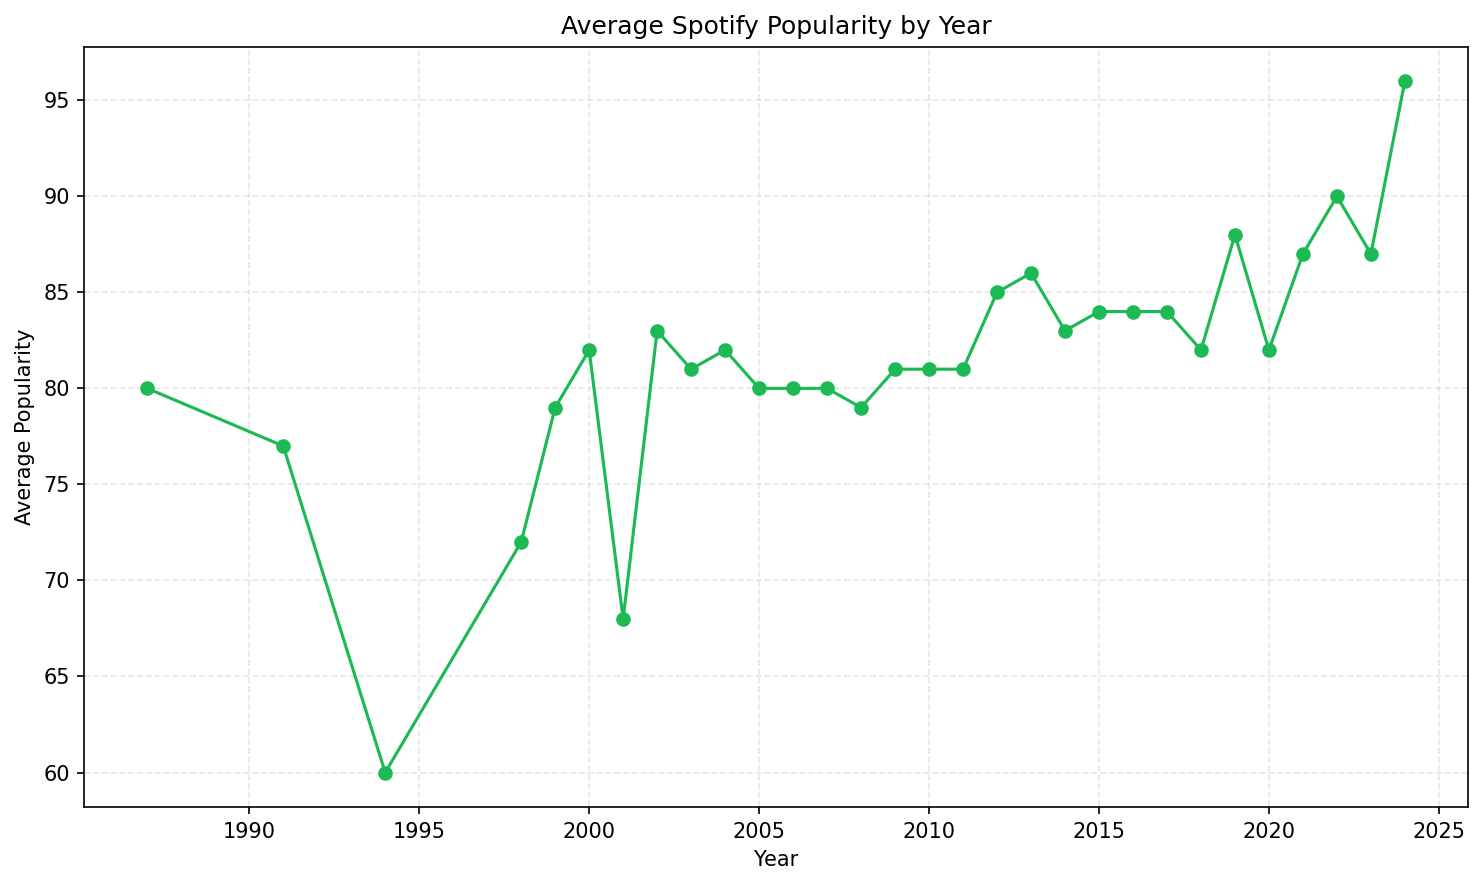

In [72]:
year_avg_popularity = df.groupby('Year')['Spotify Popularity'].max()

plt.figure(figsize=(10, 6), dpi = 150)
plt.plot(year_avg_popularity.index, year_avg_popularity.values, marker='o', color='#1db954')
plt.title("Average Spotify Popularity by Year")
plt.xlabel("Year")
plt.ylabel("Average Popularity")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

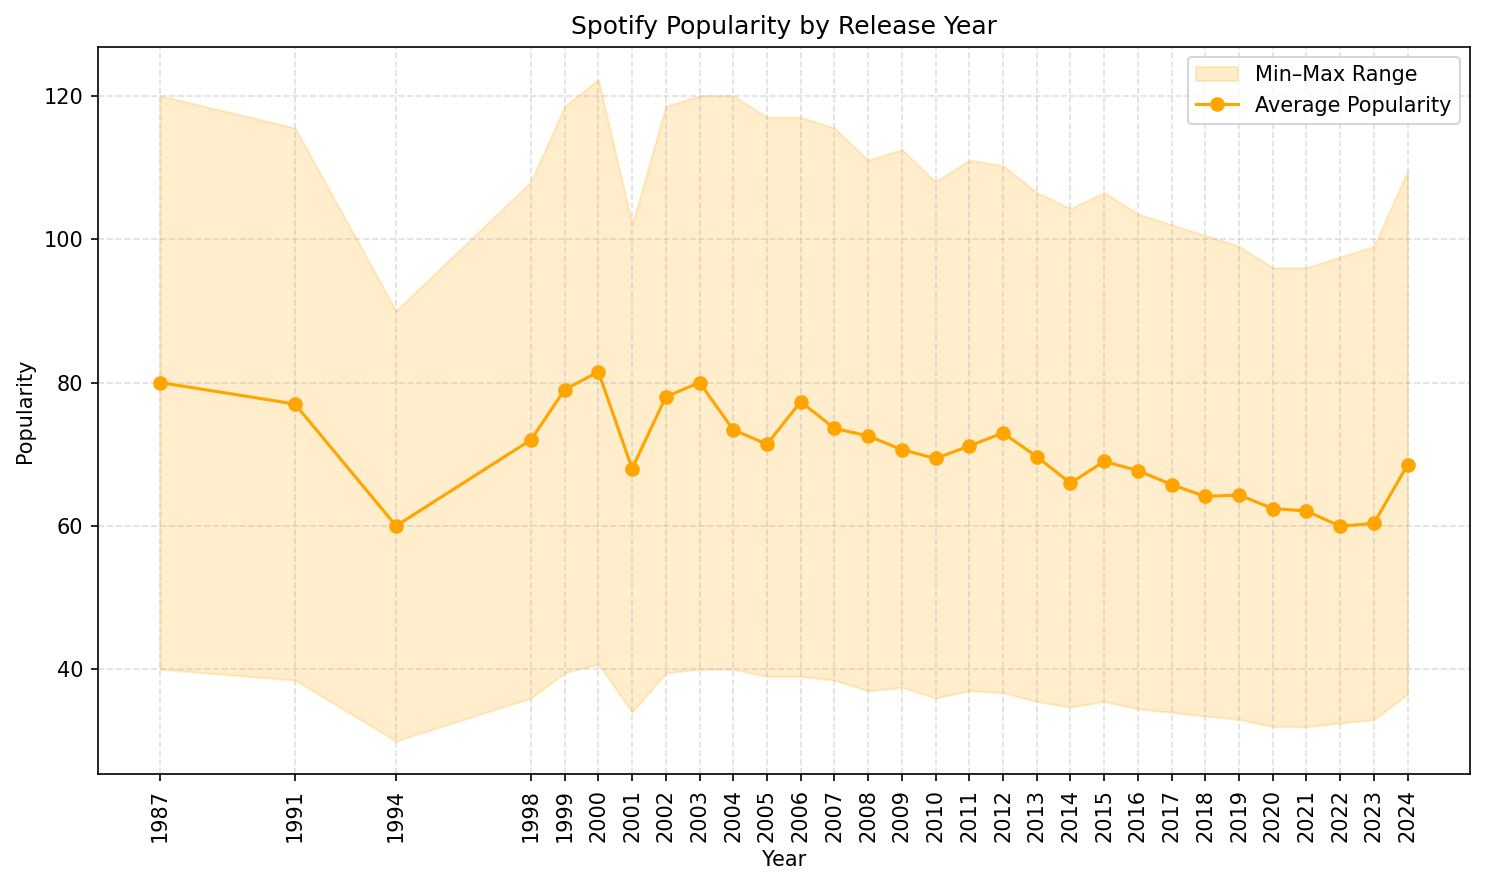

In [73]:
yearly_stats = df.groupby('Year')['Spotify Popularity'].agg(['mean', 'median', 'max'])

# Create plot
plt.figure(figsize=(10, 6), dpi = 150)

# Fill between min and max
plt.fill_between(yearly_stats.index,
                 yearly_stats['median']*0.5,
                 yearly_stats['median']*1.5,
                 color='orange',
                 alpha=0.2,
                 label='Min–Max Range')

# Plot average line
plt.plot(yearly_stats.index,
         yearly_stats['mean'],
         color='orange',
         marker='o',
         label='Average Popularity')

# --- Fix x-ticks ---
plt.xticks(ticks=yearly_stats.index, rotation=90)

# --- Labels and formatting ---
plt.title('Spotify Popularity by Release Year')
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [74]:
# Make a copy to avoid modifying original
df_explicit = df.copy()

# Compare average engagement metrics
engagement_cols = [
    'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach',
    'Spotify Popularity', 'YouTube Views', 'YouTube Likes',
    'TikTok Posts', 'TikTok Likes', 'TikTok Views',
    'Apple Music Playlist Count', 'Shazam Counts'
]

grouped_means = df_explicit.groupby('Explicit Track')[engagement_cols].mean().T
grouped_means.columns = ['Non-Explicit', 'Explicit']

# Percent difference in performance
percent_diff = ((grouped_means['Explicit'] - grouped_means['Non-Explicit']) / grouped_means['Non-Explicit']) * 100
percent_diff = percent_diff.sort_values(ascending=False)
print("% Difference (Explicit vs Non-Explicit):\n", percent_diff.round(2), "\n")

% Difference (Explicit vs Non-Explicit):
 Spotify Playlist Count        34.94
Spotify Popularity             3.95
Spotify Playlist Reach         2.55
Spotify Streams               -0.72
Apple Music Playlist Count   -12.54
TikTok Likes                 -12.76
TikTok Views                 -18.13
TikTok Posts                 -25.65
Shazam Counts                -28.86
YouTube Likes                -32.95
YouTube Views                -45.94
dtype: float64 



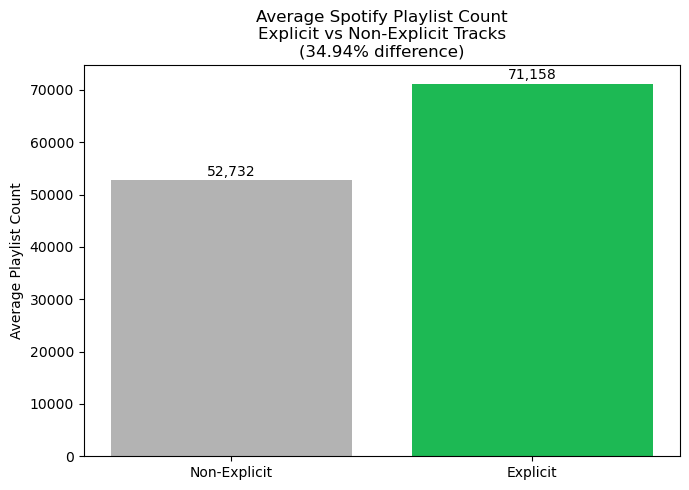

In [75]:
# Bar chart for Spotify Playlist Count
playlist_counts = grouped_means.loc['Spotify Playlist Count']
percent_diff_value = percent_diff['Spotify Playlist Count']

plt.figure(figsize=(7, 5))
bars = plt.bar(['Non-Explicit', 'Explicit'], playlist_counts, color=[spotify_light_gray, spotify_green])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 250, f'{yval:,.0f}', ha='center', va='bottom')

plt.title(f"Average Spotify Playlist Count\nExplicit vs Non-Explicit Tracks\n({percent_diff_value:.2f}% difference)")
plt.ylabel('Average Playlist Count')
plt.tight_layout()
plt.show()